初めて作成して動いた記念すべきグラフニューラルネットワーク第1号！！！ポンコツだったけどおめでたい！！！

In [1]:
from rdkit import Chem
import rdkit
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm import tqdm
import numpy as np
import pickle
import torch
from torch_geometric.nn import GCNConv,global_max_pool,AGNNConv,NNConv
from torch.nn import ModuleList ,BatchNorm1d,Linear
import torch.nn.functional  as F
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# 現在の作業ディレクトリを取得
current_directory = os.getcwd()
# データセットのパスを取得
data_path = os.path.join(current_directory, 'datasets', 'dataset.csv')
#データセットを取得
df = pd.read_csv(data_path)

In [3]:
target = df["λmax"]

In [4]:
def smiles_to_atom_feature(smiles : str, res_type='tensor'):
    mol = rdkit.Chem.MolFromSmiles(smiles)
    if mol is None:
        mol = rdkit.Chem.MolFromSmiles('')
    xs = []
    for atom in mol.GetAtoms():
        x = []
        x.append(atom.GetSymbol() == 'B')
        x.append(atom.GetSymbol() == 'C')
        x.append(atom.GetSymbol() == 'F')
        x.append(atom.GetSymbol() == 'H')
        x.append(atom.GetSymbol() == 'N')
        x.append(atom.GetSymbol() == 'O')
        x.append(atom.GetSymbol() == 'P')
        x.append(atom.GetSymbol() == 'S')

        x.append(str(atom.GetChiralTag()) == 'CHI_UNSPECIFIED')
        x.append(str(atom.GetChiralTag()) == 'CHI_TETRAHEDRAL_CW')
        x.append(str(atom.GetChiralTag()) == 'CHI_TETRAHEDRAL_CCW')
        x.append(str(atom.GetChiralTag()) == 'CHI_OTHER')

        for degree in range(11):
            x.append(atom.GetTotalDegree() == degree)

        for formal_charge in range(-5,6):
            x.append(atom.GetFormalCharge() == formal_charge)

        for num_hs in range(7):
            x.append(atom.GetTotalNumHs() == num_hs)

        for num_radical_electrons in range(10):
            x.append(atom.GetNumRadicalElectrons() == num_radical_electrons)
            
        x.append(str(atom.GetHybridization()) == 'UNSPECIFIED')
        x.append(str(atom.GetHybridization()) == 'S')
        x.append(str(atom.GetHybridization()) == 'SP')
        x.append(str(atom.GetHybridization()) == 'SP2')
        x.append(str(atom.GetHybridization()) == 'SP3')
        x.append(str(atom.GetHybridization()) == 'SP3D')
        x.append(str(atom.GetHybridization()) == 'SP3D2')
        x.append(str(atom.GetHybridization()) == 'OTHER')
        
        x.append(atom.GetIsAromatic() == True)

        x.append(atom.IsInRing() == True)

        xs.append(x)
    if res_type == 'tensor':
        xs = torch.tensor(xs,dtype=torch.float32)
    elif res_type == 'list':
        pass

    return xs

In [5]:
def smiles_to_bond_feature(smiles : str):
    edge_index = [[],[]]
    edge_attr = []
    mol = rdkit.Chem.MolFromSmiles(smiles)
    for bond in mol.GetBonds():
        edge_features = []
        edge_index[0].append(bond.GetBeginAtomIdx())
        edge_index[0].append(bond.GetEndAtomIdx())
        edge_index[1].append(bond.GetEndAtomIdx())
        edge_index[1].append(bond.GetBeginAtomIdx())

        edge_features.append(str(bond.GetBondType()) == 'misc')
        edge_features.append(str(bond.GetBondType()) == 'SINGLE')
        edge_features.append(str(bond.GetBondType()) == 'DOUBLE')
        edge_features.append(str(bond.GetBondType()) == 'TRIPLE')
        edge_features.append(str(bond.GetBondType()) == 'AROMATIC')

        edge_features.append(str(bond.GetStereo()) == 'STEREONONE')
        edge_features.append(str(bond.GetStereo()) == 'STEREOZ')
        edge_features.append(str(bond.GetStereo()) == 'STEREOE')
        edge_features.append(str(bond.GetStereo()) == 'STEREOCIS')
        edge_features.append(str(bond.GetStereo()) == 'STEREOTRANS')
        edge_features.append(str(bond.GetStereo()) == 'STEREOANY')

        edge_features.append(str(bond.GetIsConjugated()) == True)

        edge_attr.append(edge_features)
        edge_attr.append(edge_features)

    edge_index = torch.tensor(edge_index,dtype=torch.long)
    edge_attr = torch.tensor(edge_attr,dtype=torch.float32)

    return edge_index, edge_attr

In [6]:
class MolecularGCN2(torch.nn.Module):
    def __init__(self, node_feature_dim, edge_feature_dim, hidden_dim1,hidden_dim2,aggr,num_conv_layers):
        super(MolecularGCN2, self).__init__()
        self.activation_func = F.relu

        edge_fc1 = nn.Linear(edge_feature_dim, node_feature_dim*hidden_dim1)
        # jittable()でscriptに変換できるように
        nnconv1 = NNConv(node_feature_dim, hidden_dim1, edge_fc1, aggr=aggr).jittable()

        self.conv_list = nn.ModuleList()
        self.conv_list.append(nnconv1)

        for _ in range(num_conv_layers - 1):
            edge_fc = nn.Linear(edge_feature_dim, hidden_dim1*hidden_dim1)
            nnconv = NNConv(hidden_dim1, hidden_dim1, edge_fc, aggr=aggr).jittable()
            self.conv_list.append(nnconv)
        
        self.fc1 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc2 = nn.Linear(hidden_dim2, 1)

    def forward(self,  x, edge_index, edge_attr, batch):
        for f in self.conv_list:
            x = f(x=x,edge_index=edge_index, edge_attr=edge_attr)
            x = self.activation_func(x)
        x = global_max_pool(x,batch)
        x = self.fc1(x)
        x = self.activation_func(x)
        x = self.fc2(x)
        return x

In [7]:
smiles_column = df["SMILES"]

# ヘッダーを含むSMILESデータを作成
smiles_with_header = 'SMILES\n' + '\n'.join(smiles_column)

# 分子を作成
smiles_supplier = Chem.SmilesMolSupplierFromText(smiles_with_header, delimiter=',', titleLine=True, smilesColumn=0, nameColumn=-1)

# 分子データの取得
molecules = [mol for mol in tqdm(smiles_supplier)]

100%|██████████| 198655/198655 [00:15<00:00, 13089.78it/s]


In [8]:
# Convert SMILES strings to atom features
atom_features = [smiles_to_atom_feature(smiles) for smiles in smiles_column]

In [94]:
print(atom_features[1].shape)

torch.Size([17, 61])


In [9]:
bond_features = [smiles_to_bond_feature(smiles) for smiles in smiles_column]

In [10]:
# Separate edge_index and edge_attr into different lists
edge_index, edge_attrs = zip(*bond_features)

In [90]:
print(edge_index[1].shape)

torch.Size([2, 38])


In [92]:
print(edge_attrs[1].shape)

torch.Size([38, 12])


In [11]:
import torch
from torch.utils.data import Dataset

class MoleculeDataset(Dataset):
    def __init__(self, atom_features, edge_index, edge_attrs, targets):
        self.atom_features = atom_features
        self.edge_indices = edge_index
        self.edge_attrs = edge_attrs
        self.targets = targets  # ターゲットを追加します

        # 最大の原子数とエッジ数を見つけます
        self.max_num_atoms = max(x.shape[0] for x in atom_features)
        self.max_num_edges = max(x.shape[1] for x in edge_index)

    def __len__(self):
        return len(self.atom_features)

    def __getitem__(self, idx):
        # パディングを行います
        pad_size_atoms = self.max_num_atoms - self.atom_features[idx].shape[0]
        padded_atom_features = F.pad(self.atom_features[idx], (0, 0, 0, pad_size_atoms))
        
        pad_size_edges = self.max_num_edges - self.edge_indices[idx].shape[1]
        padded_edge_indices = F.pad(self.edge_indices[idx], (0, pad_size_edges))
        
        return padded_atom_features, padded_edge_indices, self.edge_attrs[idx], self.targets[idx]

# targetsを適切に定義します
dataset = MoleculeDataset(atom_features, edge_index, edge_attrs, target)

In [12]:
from torch_geometric.data import Data

class MoleculeDataset(Dataset):
    def __init__(self, atom_features, edge_index, edge_attrs, targets):
        self.data_list = []
        for atom_features, edge_index, edge_attrs, target in zip(atom_features, edge_index, edge_attrs, targets):
            data = Data(x=atom_features, edge_index=edge_index, edge_attr=edge_attrs, y=target)
            self.data_list.append(data)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]

dataset = MoleculeDataset(atom_features, edge_index, edge_attrs, target)

In [121]:
print(dataset[2])

Data(x=[16, 61], edge_index=[2, 36], edge_attr=[36, 12], y=225.09178161621094)


In [13]:
from torch_geometric.data import DataLoader as GeometricDataLoader
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch.nn import MSELoss
from torch.cuda import is_available
from torch_geometric.data import Batch

# データセットを学習データとテストデータに分割
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# データローダーを作成
train_loader = GeometricDataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = GeometricDataLoader(test_dataset, batch_size=32)

# モデルとオプティマイザを定義
model = MolecularGCN2(61,12,num_conv_layers=5, hidden_dim1=61, hidden_dim2= 162, aggr= 'add')
optimizer = Adam(model.parameters(), lr=0.001)

# GPUを利用
device = 'cuda' if is_available() else 'cpu'

# モデルをGPUに移動
model = model.to(device)

# 損失関数を定義
criterion = MSELoss()

# 学習エポック数を設定
epochs = 100

# 学習率スケジューラーを設定
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 000, Test MSE: 14053.37012
Epoch: 001, Test MSE: 3382.35010
Epoch: 002, Test MSE: 9112.06934
Epoch: 003, Test MSE: 6693.40674
Epoch: 004, Test MSE: 3444.74536
Epoch: 005, Test MSE: 4166.74023
Epoch: 006, Test MSE: 6596.08887
Epoch: 007, Test MSE: 8022.47510
Epoch: 008, Test MSE: 7680.59814
Epoch: 009, Test MSE: 6004.40723
Epoch: 010, Test MSE: 4015.02979
Epoch: 011, Test MSE: 2784.26978
Epoch: 012, Test MSE: 2790.07153
Epoch: 013, Test MSE: 3103.63550
Epoch: 014, Test MSE: 2790.82617
Epoch: 015, Test MSE: 2296.86353
Epoch: 016, Test MSE: 2277.90259
Epoch: 017, Test MSE: 2793.15479
Epoch: 018, Test MSE: 3420.08081
Epoch: 019, Test MSE: 3755.91577
Epoch: 020, Test MSE: 3701.70776
Epoch: 021, Test MSE: 3454.74219
Epoch: 022, Test MSE: 3084.70947
Epoch: 023, Test MSE: 2677.98242
Epoch: 024, Test MSE: 2312.32812
Epoch: 025, Test MSE: 2064.94824
Epoch: 026, Test MSE: 1946.84875
Epoch: 027, Test MSE: 1922.33887
Epoch: 028, Test MSE: 1928.85754
Epoch: 029, Test MSE: 1921.39954
Epoch: 03

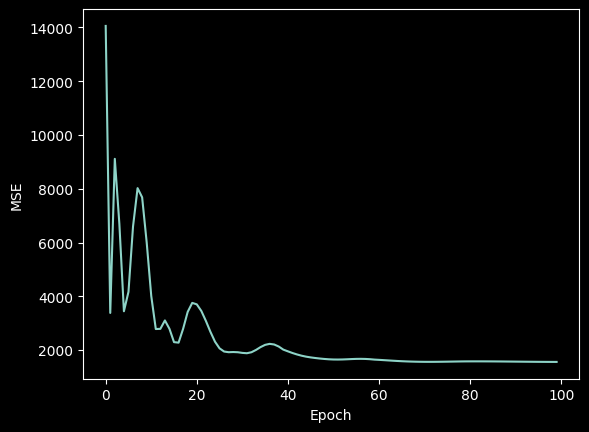

In [201]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# 損失を保存するリストを作成
train_losses = []
test_losses = []

# 学習ループ
for epoch in range(epochs):
    model.train()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = criterion(out, data.y.view(-1, 1).to(device))
        loss.backward()
        optimizer.step()
    scheduler.step()

    # テストループ
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = criterion(out, data.y.view(-1, 1).to(device))
            total_test_loss += loss.item()
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    print('Epoch: {:03d}, Test MSE: {:.5f}'.format(epoch, avg_test_loss))

# 損失の変化をプロット
plt.plot(test_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

In [211]:
class MolecularGCN2(torch.nn.Module):
    def __init__(self, node_feature_dim, edge_feature_dim, hidden_dim1,hidden_dim2,aggr,num_conv_layers, dropout_rate):
        super(MolecularGCN2, self).__init__()
        self.activation_func = F.relu
        self.dropout = nn.Dropout(dropout_rate)
        self.batch_norm = nn.BatchNorm1d(hidden_dim1)

        edge_fc1 = nn.Linear(edge_feature_dim, node_feature_dim*hidden_dim1)
        nnconv1 = NNConv(node_feature_dim, hidden_dim1, edge_fc1, aggr=aggr).jittable()

        self.conv_list = nn.ModuleList()
        self.conv_list.append(nnconv1)

        for _ in range(num_conv_layers - 1):
            edge_fc = nn.Linear(edge_feature_dim, hidden_dim1*hidden_dim1)
            nnconv = NNConv(hidden_dim1, hidden_dim1, edge_fc, aggr=aggr).jittable()
            self.conv_list.append(nnconv)
        
        self.fc1 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc2 = nn.Linear(hidden_dim2, 1)

    def forward(self,  x, edge_index, edge_attr, batch):
        for f in self.conv_list:
            x = f(x=x,edge_index=edge_index, edge_attr=edge_attr)
            x = self.activation_func(x)
            x = self.dropout(x)
        x = global_max_pool(x,batch)
        x = self.fc1(x)
        x = self.activation_func(x)
        x = self.fc2(x)
        return x

# モデルの作成
model = MolecularGCN2(61,12,num_conv_layers=5, hidden_dim1=70, hidden_dim2= 162, aggr= 'add', dropout_rate=0.5)


In [218]:
from torch_geometric.data import DataLoader as GeometricDataLoader
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch.nn import MSELoss
from torch.cuda import is_available
from torch_geometric.data import Batch

# データセットを学習データとテストデータに分割
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# データローダーを作成
train_loader = GeometricDataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = GeometricDataLoader(test_dataset, batch_size=64)

# GPUを利用
device = 'cuda' if is_available() else 'cpu'

# モデルをGPUに移動
model = model.to(device)

# 損失関数を定義
criterion = MSELoss()

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [220]:
import optuna

epochs = 1000

def objective(trial):
    # ハイパーパラメータの設定
    hidden_dim1 = trial.suggest_int('hidden_dim1', 50, 200)
    hidden_dim2 = trial.suggest_int('hidden_dim2', 50, 200)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    step_size = trial.suggest_int('step_size', 1, 100)
    gamma = trial.suggest_uniform('gamma', 0.0, 1)
    
    # モデルの作成
    model = MolecularGCN2(61, 12, num_conv_layers=5, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, aggr='add', dropout_rate=dropout_rate)
    model = model.to(device)

    # オプティマイザの作成
    optimizer = Adam(model.parameters(), lr=lr)
    
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

    # 学習ループ
    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = criterion(out, data.y.view(-1, 1).to(device))
            loss.backward()
            optimizer.step()
        scheduler.step()

        # テストループ
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                out = model(data.x, data.edge_index, data.edge_attr, data.batch)
                loss = criterion(out, data.y.view(-1, 1).to(device))
                total_test_loss += loss.item()
        avg_test_loss = total_test_loss / len(test_loader)

        # Optunaにテストロスを報告
        trial.report(avg_test_loss, epoch)

        # 途中で試行を停止するかどうかを判断
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return avg_test_loss

# Optunaのスタディを作成
study = optuna.create_study(direction='minimize')

# スタディの最適化を実行
study.optimize(objective, n_trials=1000)
print(study.best_params)
print(study.best_value)

[I 2023-12-11 22:30:59,771] A new study created in memory with name: no-name-d18dfc06-a20e-4374-94df-86413df64d37
C:\Users\user\AppData\Local\Temp\ipykernel_28244\4154010852.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
C:\Users\user\AppData\Local\Temp\ipykernel_28244\4154010852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
C:\Users\user\AppData\Local\Temp\ipykernel_28244\4154010852.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float i

{'hidden_dim1': 186, 'hidden_dim2': 134, 'dropout_rate': 0.010645477085265552, 'lr': 3.7730180224583514e-05, 'step_size': 59, 'gamma': 0.9867319374019765}
807.2369384765625


In [209]:
print(study.best_params)
print(study.best_value)

{'hidden_dim1': 77, 'hidden_dim2': 191, 'num_conv_layers': 3, 'dropout_rate': 0.09330227126261632, 'lr': 0.04004192604615772, 'step_size': 63, 'gamma': 0.3781921473938066}
1687.301025390625


{'hidden_dim1': 64, 'hidden_dim2': 140, 'num_conv_layers': 4, 'dropout_rate': 0.01922489647670058, 'lr': 0.006332314179193385, 'step_size': 28, 'gamma': 0.37394789672090656}
654.2669067382812

Epoch: 000, Test MSE: 32030.16016
Epoch: 001, Test MSE: 9915.94238
Epoch: 002, Test MSE: 17963.79297
Epoch: 003, Test MSE: 13106.29199
Epoch: 004, Test MSE: 4585.42432
Epoch: 005, Test MSE: 14104.26562
Epoch: 006, Test MSE: 3726.69604
Epoch: 007, Test MSE: 5600.14697
Epoch: 008, Test MSE: 9266.81250
Epoch: 009, Test MSE: 9216.15723
Epoch: 010, Test MSE: 5862.46436
Epoch: 011, Test MSE: 2368.94995
Epoch: 012, Test MSE: 2454.96558
Epoch: 013, Test MSE: 1833.66077
Epoch: 014, Test MSE: 1874.75818
Epoch: 015, Test MSE: 3750.74170
Epoch: 016, Test MSE: 4847.44775
Epoch: 017, Test MSE: 4043.44092
Epoch: 018, Test MSE: 2182.78418
Epoch: 019, Test MSE: 998.65613
Epoch: 020, Test MSE: 1116.91235
Epoch: 021, Test MSE: 918.11182
Epoch: 022, Test MSE: 956.02130
Epoch: 023, Test MSE: 1768.43652
Epoch: 024, Test MSE: 2441.85889
Epoch: 025, Test MSE: 2237.74780
Epoch: 026, Test MSE: 1444.86938
Epoch: 027, Test MSE: 837.04480
Epoch: 028, Test MSE: 767.20276
Epoch: 029, Test MSE: 743.38293
Epoch: 030, 

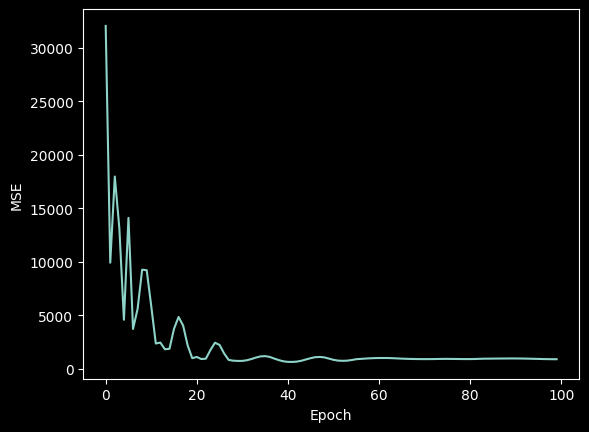

In [217]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# 損失を保存するリストを作成
train_losses = []
test_losses = []

model = MolecularGCN2(61, 12, num_conv_layers=4, hidden_dim1=64, hidden_dim2=140, aggr='add', dropout_rate=0.01922489647670058)
model = model.to(device)

# オプティマイザの作成
optimizer = Adam(model.parameters(), lr=0.00633231417919338)
    
scheduler = StepLR(optimizer, step_size=28, gamma=0.37394789672090656)

# 学習ループ
for epoch in range(epochs):
    model.train()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = criterion(out, data.y.view(-1, 1).to(device))
        loss.backward()
        optimizer.step()
    scheduler.step()

    # テストループ
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = criterion(out, data.y.view(-1, 1).to(device))
            total_test_loss += loss.item()
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    print('Epoch: {:03d}, Test MSE: {:.5f}'.format(epoch, avg_test_loss))

# 損失の変化をプロット
plt.plot(test_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()